# Test keypoints.py functionality

In [2]:
import os
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image

import data
import models
import pvnet_utils
import keypoints
reload(keypoints)
reload(pvnet_utils)

ROOT_DIR = "../dataset/LINEMOD"

In [3]:
reload(data)
x_train, x_test, y_train, y_test = pvnet_utils.get_test_train_split(ROOT_DIR,['duck', 'cat', 'lamp'], 
                                                                    test_size=0.33, 
                                                                    random_state=2, 
                                                                    shuffle=True)

train_dataset = data.LineModReader((x_train, y_train))
test_dataset = data.LineModReader((x_test, y_test))



### Prepare dummy data from gt labels

In [4]:
import training
reload(training)

sample = train_dataset[0]

keypointVector = torch.Tensor(sample['class_vectormap']).permute(2,0,1).unsqueeze(0)

padded_label = training._padded_vector_label(keypoint_vector_label = keypointVector,
    class_Label=sample['class_label'],
    num_classes=12,
    num_keypoints=9)

print(padded_label.size())

padded_segmentation = torch.zeros(1, 12 + 1, sample['class_mask'].shape[0], sample['class_mask'].shape[1])
padded_segmentation[0,sample['class_label'],:,:] = sample['class_mask']
print(padded_segmentation.size())


[1, 18, 480, 640]
torch.Size([1, 216, 480, 640])
torch.Size([1, 13, 480, 640])


tensor(0.4425)


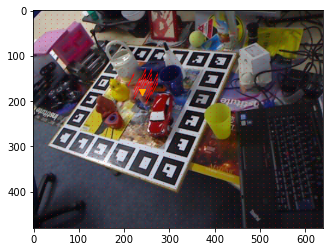

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.8706, 0.8706, 0.8706],
         [0.0000, 0.0000, 0.0000,  ..., 0.8706, 0.8706, 0.8706],
         [0.0000, 0.0000, 0.0000,  ..., 0.8706, 0.8706, 0.8706]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.4919, 0.4919, 0.4919],
         [0.0000, 0.0000, 0.0000,  ..., 0.4919, 0.4919, 0.4919],
         [0.0000, 0.0000, 0.0000,  ..., 0.4919, 0.4919, 0.4919]]])
torch.Size([1, 13, 480, 640])
tensor([[  0, 153, 242],
        [  0, 153, 243],
        [  0, 153, 244],
        ...,
        [  0, 210, 252],
        [  0, 210, 253],
        [  0, 210, 2

In [31]:
reload(keypoints)
b, c, h, w = keypointVector.size()

x,y = np.meshgrid(np.linspace(0,w-1,50),np.linspace(0,h-1,50))

v,u = keypointVector[0,4:6,y,x]

print(u.max())

plt.imshow(train_dataset.tensorToImage(sample['img']))
plt.quiver(x,y,u,v, color= 'red', scale = 5, scale_units = 'inches')
plt.scatter(sample['obj_keypoints'][2][0], sample['obj_keypoints'][2][1], marker='v', color="orange")

plt.show()

print(keypointVector[0,0:2,150:200,200:250])

vectorpts = keypoints.findKeypoints(
    padded_segmentation,
    padded_label,
    [sample['class_label']]
)

# for k in range(0,5):
#     print(k)
#     print(vectorpts[::500,k])